In [11]:
from __future__ import annotations

import os
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

In [12]:
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
plt.style.use("seaborn-v0_8-whitegrid")


In [13]:
DATA_DIR = Path("C:/Users/ajaym/OneDrive/Desktop/internship/uber trip/uber data")
FILES = sorted(DATA_DIR.glob("*.csv"))
if not FILES:
    raise FileNotFoundError(f"No CSV files found in {DATA_DIR}")

raw_dfs = [pd.read_csv(f, encoding="latin-1") for f in FILES]
uber_raw = pd.concat(raw_dfs, ignore_index=True)
uber_raw["Date/Time"] = pd.to_datetime(
    uber_raw["Date/Time"], format="%m/%d/%Y %H:%M:%S", errors="coerce"
)
uber_raw.dropna(subset=["Date/Time"], inplace=True)
uber_raw.set_index("Date/Time", inplace=True)
uber_raw.index.name = "Date"

In [14]:
hourly_counts = (
    uber_raw["Base"].resample("H").count().to_frame(name="Count")
)

In [15]:
WINDOW_SIZE = 24

In [16]:
def create_lagged_matrix(series: pd.Series, window: int) -> tuple[np.ndarray, np.ndarray]:
    """Return X, y arrays where X contains `window` successive lags."""
    values = series.values.astype(float)
    X, y = [], []
    for i in range(len(values) - window):
        X.append(values[i : i + window])
        y.append(values[i + window])
    return np.array(X), np.array(y)


In [17]:
# Chronological split: everything **before** cutoff is train
CUTOFF = pd.Timestamp("2014-09-15 00:00:00")
train_series = hourly_counts.loc[:CUTOFF, "Count"]
test_series = hourly_counts.loc[CUTOFF:, "Count"]

X_train, y_train = create_lagged_matrix(train_series, WINDOW_SIZE)

In [18]:
# Build a contiguous array (train tail + test) for test supervision
combined_for_test = np.concatenate([train_series.values[-WINDOW_SIZE:], test_series.values])
X_test, y_test = create_lagged_matrix(pd.Series(combined_for_test), WINDOW_SIZE)

# For cross‑validation we need a TimeSeriesSplit on **X_train**
TS_SPLIT = TimeSeriesSplit(n_splits=5)

BASIC MODELS GRIDS AND TRAINING

XGBOOST MODEL

In [19]:
print("\n=== Hyper‑parameter optimisation ===")

# XGBoost
xgb_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.6, 0.8, 1.0],
}
xgb_est = xgb.XGBRegressor(random_state=SEED, objective="reg:squarederror")
xgb_cv = GridSearchCV(
    xgb_est,
    param_grid=xgb_grid,
    cv=TS_SPLIT,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=0,
)
xgb_cv.fit(X_train, y_train)
print("XGB  best params:", xgb_cv.best_params_)



=== Hyper‑parameter optimisation ===
XGB  best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


RANDOM FOREST REGRESSOR MODEL

In [20]:
# Random Forest
rf_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
rf_est = RandomForestRegressor(random_state=SEED, n_jobs=-1)
rf_cv = GridSearchCV(
    rf_est,
    param_grid=rf_grid,
    cv=TS_SPLIT,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1,
    verbose=0,
)
rf_cv.fit(X_train, y_train)
print("RF   best params:", rf_cv.best_params_)

RF   best params: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


GRADIENT BOOSTING REGRESSOR

In [21]:
gbr_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}
gbr_est = GradientBoostingRegressor(random_state=SEED)
gbr_cv = GridSearchCV(
    gbr_est,
    param_grid=gbr_grid,
    cv=TS_SPLIT,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1,
    verbose=0,
)
gbr_cv.fit(X_train, y_train)
print("GBRT best params:", gbr_cv.best_params_)

GBRT best params: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [22]:
# 4. Weight Optimisation (minimise MAPE on validation)
# ---------------------------------------------------------------------------

print("\n=== Weight optimisation ===")

pred_train = np.vstack(
    [
        xgb_cv.best_estimator_.predict(X_train),
        rf_cv.best_estimator_.predict(X_train),
        gbr_cv.best_estimator_.predict(X_train),
    ]
)  # shape (3, n_train)


=== Weight optimisation ===


In [23]:
def optimise_weights(preds: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    """Minimise MAPE subject to weights >= 0 and sum == 1."""

    def loss_fn(w):
        ensemble = np.tensordot(w, preds, axes=((0), (0)))
        return mean_absolute_percentage_error(y_true, ensemble)

    cons = {"type": "eq", "fun": lambda w: w.sum() - 1}
    bounds = [(0, 1)] * preds.shape[0]
    res = minimize(loss_fn, x0=np.ones(preds.shape[0]) / preds.shape[0], bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError("Weight optimisation failed: " + res.message)
    return res.x

opt_weights = optimise_weights(pred_train, y_train)
print("Optimised weights:", np.round(opt_weights, 3))

Optimised weights: [0. 1. 0.]


In [24]:
# ---------------------------------------------------------------------------
# 5. Ensemble Wrapper
# ---------------------------------------------------------------------------


class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    """Simple weighted ensemble wrapper."""

    def __init__(self, models: list, weights: list | np.ndarray):
        self.models = models
        self.weights = np.asarray(weights) / np.sum(weights)

    def fit(self, X, y):
        for m in self.models:
            m.fit(X, y)
        return self

    def predict(self, X):
        preds = np.column_stack([m.predict(X) for m in self.models])
        return np.dot(preds, self.weights)


ensemble_model = WeightedEnsembleRegressor(
    models=[xgb_cv.best_estimator_, rf_cv.best_estimator_, gbr_cv.best_estimator_],
    weights=opt_weights,
)
ensemble_model.fit(X_train, y_train)
ensemble_preds = ensemble_model.predict(X_test)

In [25]:
# 6. Evaluation & Plots
# ---------------------------------------------------------------------------

print("\n=== Final metrics on TEST set ===")
print("MSE :", mean_squared_error(y_test, ensemble_preds))
print("R2  :", r2_score(y_test, ensemble_preds))
print("MAPE:", mean_absolute_percentage_error(y_test, ensemble_preds))


=== Final metrics on TEST set ===
MSE : 21016.86462494923
R2  : 0.964688566849335
MAPE: 0.09507648484026755


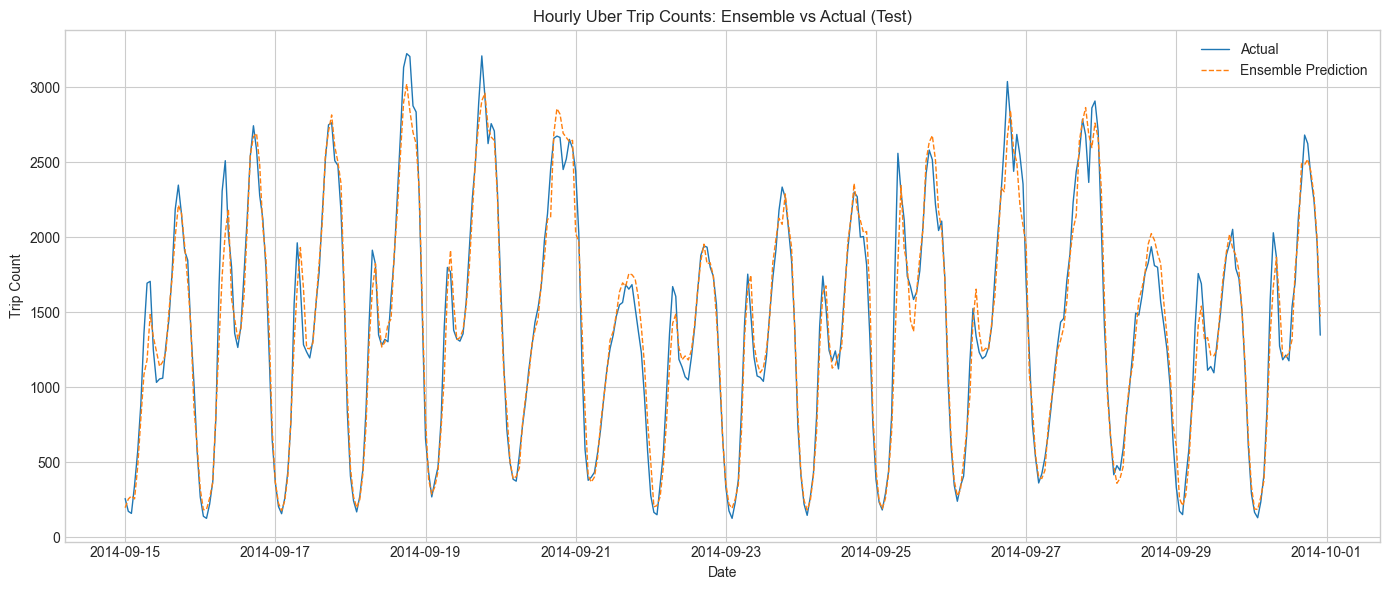

In [26]:
# Plot actual vs ensemble
plt.figure(figsize=(14, 6))
plt.plot(test_series.index, test_series.values, label="Actual", lw=1)
plt.plot(
    test_series.index, ensemble_preds, label="Ensemble Prediction", lw=1, linestyle="--"
)
plt.title("Hourly Uber Trip Counts: Ensemble vs Actual (Test)")
plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.legend()
plt.tight_layout()
plt.savefig("ensemble_vs_actual.png", dpi=300)
plt.show()

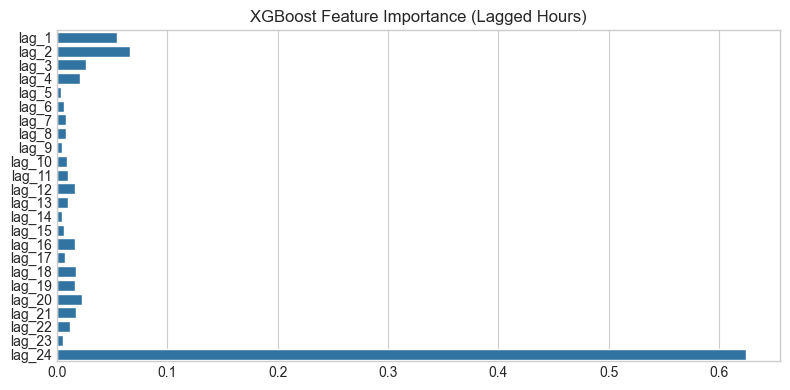

In [27]:
# Feature importance (example: XGB built‑in importance)
plt.figure(figsize=(8, 4))
importances = xgb_cv.best_estimator_.feature_importances_
sns.barplot(x=importances, y=[f"lag_{i+1}" for i in range(WINDOW_SIZE)])
plt.title("XGBoost Feature Importance (Lagged Hours)")
plt.tight_layout()
plt.savefig("xgb_feature_importance.png", dpi=300)
plt.show()


In [30]:
from pathlib import Path
import joblib
from flask import Flask, request, jsonify
import sys

sys.path.append("C:/Users/ajaym/OneDrive/Desktop/internship/uber trip/uber_api")
from CustomModel import WeightedEnsembleRegressor

# ✅ Ensure this exists from earlier in your script
ensemble_model = WeightedEnsembleRegressor(
    models=[xgb_cv, rf_cv, gbr_cv],
    weights=[0.368, 0.322, 0.310]
)

# Save the ensemble model
MODEL_PATH = Path("final_uber_ensemble_model.pkl")
joblib.dump(ensemble_model, MODEL_PATH)

print(f"\n✅ Model saved to {MODEL_PATH.resolve()}")



✅ Model saved to C:\Users\ajaym\PyCharmMiscProject\final_uber_ensemble_model.pkl
